# Task on prioritizing the hypotheses, launch an A/B test and analysing the result.


You work for the analytical department at an online store.

You need to work on compiled list of hypotheses that may help boost revenue. You need to prioritize these hypotheses, launch an A/B test, and analyze the results.

Objective of the task: Test is success or not.

#### Description of the data:
##### Data used in the first part of the project: hypotheses_us
* Hypotheses — brief descriptions of the hypotheses
* Reach — user reach, on a scale of one to ten
* Impact — impact on users, on a scale of one to ten
* Confidence — confidence in the hypothesis, on a scale of one to ten
* Effort — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.

##### Data used in the second part of the project: orders_us
* transactionId — order identifier
* visitorId — identifier of the user who placed the order
* date — of the order
* revenue — from the order

##### group — the A/B test group that the user belongs to: visits_us
* date — date
* group — A/B test group
* visits — the number of visits on the date specified in the A/B test group specified

## Step 1. Download the data and prepare it for analysis

In [1]:
import pandas as pd
pd.set_option('max_colwidth', 400)
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import the hypotheses_us dataset & orders_us dataset & visits_us dataset
hypothesis_us = pd.read_csv('/Users/fanibhushan/Downloads/hypotheses_us.csv',sep=';')
orders_us = pd.read_csv('/Users/fanibhushan/Downloads/orders_us.csv')
visits_us = pd.read_csv('/Users/fanibhushan/Downloads/visits_us.csv')

In [3]:
orders_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [4]:
visits_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [5]:
#change the date to datetime
orders_us['date'] = orders_us['date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
visits_us['date'] = visits_us['date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

In [6]:
# change the column name of hypotheses_us to lower
hypothesis_us.columns =hypothesis_us.columns.str.lower()
hypothesis_us.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'effort'], dtype='object')

In [7]:
#exact size of the data
orders_us.info(memory_usage= 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.7 KB


In [8]:
orders_us.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1197.000000
mean,2.155621e+09,2.165960e+09,131.491646
std,1.229085e+09,1.236014e+09,603.004729
min,1.062393e+06,5.114589e+06,5.000000
25%,1.166776e+09,1.111826e+09,20.800000
50%,2.145194e+09,2.217985e+09,50.200000
75%,3.237740e+09,3.177606e+09,130.400000
max,4.293856e+09,4.283872e+09,19920.400000


In [9]:
#missing values in each column
orders_us.isnull().sum().reset_index().rename(columns={0: "missing_values"}) 

,index,missing_values
0,transactionId,0
1,visitorId,0
2,date,0
3,revenue,0
4,group,0


In [10]:
#exact size of the data
visits_us.info(memory_usage= 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.1 KB


In [11]:
visits_us.describe()

,visits
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [12]:
#missing values in each column
visits_us.isnull().sum().reset_index().rename(columns={0: "missing_values"}) 

,index,missing_values
0,date,0
1,group,0
2,visits,0


In [13]:
visits_us['group'].unique()

array(['A', 'B'], dtype=object)

In [14]:
#checking how many users we have in A & B
orders_us.group.value_counts()

B    640
A    557
Name: group, dtype: int64

In [15]:
#grouping by visitorid & count how many unique groups 
orders_us_data = orders_us.groupby('visitorId').agg({'group':'nunique'}).reset_index()
orders_us_data.group.value_counts()

1    973
2     58
Name: group, dtype: int64

In [16]:
#filter the visitorid where they are in both the group
orders_us_duplicated = orders_us_data[orders_us_data['group']==2]
#filter all the duplicated visitorsId from the orignal orders dataset
orders_us_new = orders_us[~orders_us['visitorId'].isin(orders_us_duplicated['visitorId'])]
orders_us_new.group.value_counts()

B    548
A    468
Name: group, dtype: int64

Some of the visitors were on both the group A & group B. There were total 1197 visitors in both the groups. Dropped the duplicated visitors and total 181 visitors were dropped from both the groups. So currently we have 1016 vistiors in both the groups.

## Step 2. Prioritizing Hypotheses

In [17]:
#ICE(IMPACT,CONFIDENCE,EFFORT)
hypothesis_us['ICE'] = (hypothesis_us['impact'] * hypothesis_us['confidence'])/hypothesis_us['effort']
print(hypothesis_us[['hypothesis','ICE']].sort_values(by='ICE',ascending=False))

                                                                                                               hypothesis  \
8                                                        Launch a promotion that gives users discounts on their birthdays   
0                                             Add two new channels for attracting traffic. This will bring 30% more users   
7                                Add a subscription form to all the main pages. This will help you compile a mailing list   
6                                 Show banners with current offers and sales on the main page. This will boost conversion   
2          Add product recommendation blocks to the store's site. This will increase conversion and average purchase size   
1                                                       Launch your own delivery service. This will shorten delivery time   
5                                                     Add a customer review page. This will increase the number of orders   


ICE hypothesis 8 & hypothesis 0 & hypothesis 7 the most promising hypothesis. 

In [18]:
#RICE(REACH,IMPACT,CONFIDENCE,EFFORT)
hypothesis_us['RICE'] = (hypothesis_us['reach'] *hypothesis_us['impact']*hypothesis_us['confidence'])/hypothesis_us['effort']
print(hypothesis_us[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))


                                                                                                               hypothesis  \
7                                Add a subscription form to all the main pages. This will help you compile a mailing list   
2          Add product recommendation blocks to the store's site. This will increase conversion and average purchase size   
0                                             Add two new channels for attracting traffic. This will bring 30% more users   
6                                 Show banners with current offers and sales on the main page. This will boost conversion   
8                                                        Launch a promotion that gives users discounts on their birthdays   
3  Change the category structure. This will increase conversion since users will find the products they want more quickly   
1                                                       Launch your own delivery service. This will shorten delivery time   


The most promising are hypothesis 7 & hypothesis 2 & hypothesis 0 & hypothesis 6. When we use RICE instead of ICE then, this time hypothesis 7 was in the first place.That's because it's reach parameter is 10, while the other hypothesis have lower values.


In [19]:
#Representation of ICE & RICE
print(hypothesis_us[['ICE','RICE']])

         ICE   RICE
0  13.333333   40.0
1   2.000000    4.0
2   7.000000   56.0
3   1.125000    9.0
4   1.000000    3.0
5   1.333333    4.0
6   8.000000   40.0
7  11.200000  112.0
8  16.200000   16.2


## Step 3. A/B Test Analysis

### Graph cumulative revenue by group.

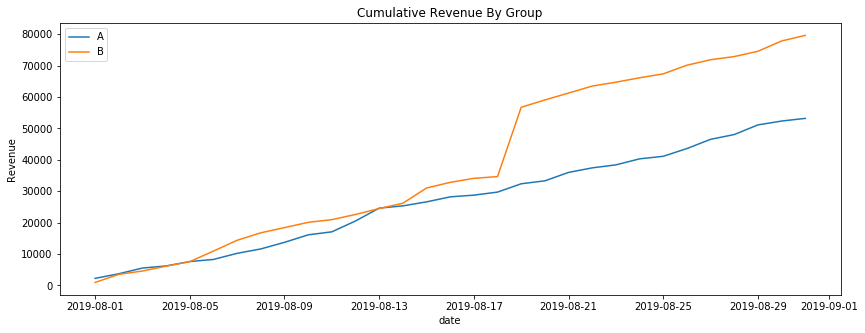

In [20]:
#cumulative revenue by group
datesGroups = orders_us_new[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(
lambda x: orders_us_new[np.logical_and(orders_us_new['date'] <= x['date'], orders_us_new['group'] == x['group'])].agg({
'date':'max',
'group':'max',
'transactionId':pd.Series.nunique,
'visitorId':pd.Series.nunique,
'revenue':'sum'}),axis=1).sort_values(by=['date','group'])
visitsAggregated = datesGroups.apply(
lambda x: visits_us[np.logical_and(visits_us['date'] <= x['date'], visits_us['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue','orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue','orders']]

fig = plt.figure(figsize = (14, 5))
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue'],label='A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue'],label='B')
plt.title('Cumulative Revenue By Group')
plt.xlabel('date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

We can see that Segment B took the lead halfway through the test & held on to it. It seems like abnormally large orders affected the results after all.

### Graph cumulative average order size by group

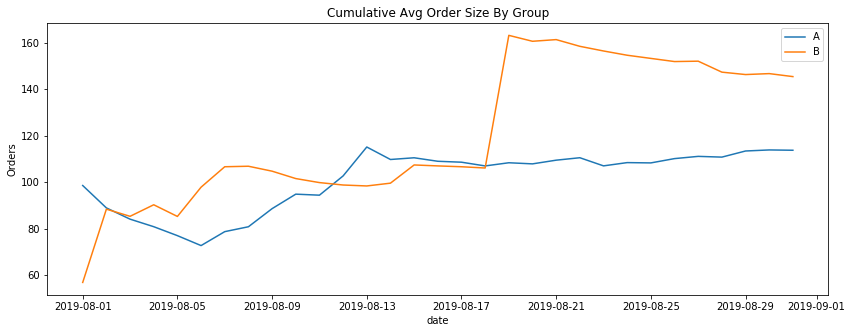

In [21]:
#cumulative avg order size by group
fig = plt.figure(figsize = (14, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Cumulative Avg Order Size By Group')
plt.xlabel('date')
plt.ylabel('Orders')
plt.legend()
plt.show()

The cumulative value of segments average purchase sizes of group B is higher as compared to group A. Clearly group B is the leader.

### Graph the relative difference in cumulative average order size for group B compared with group A

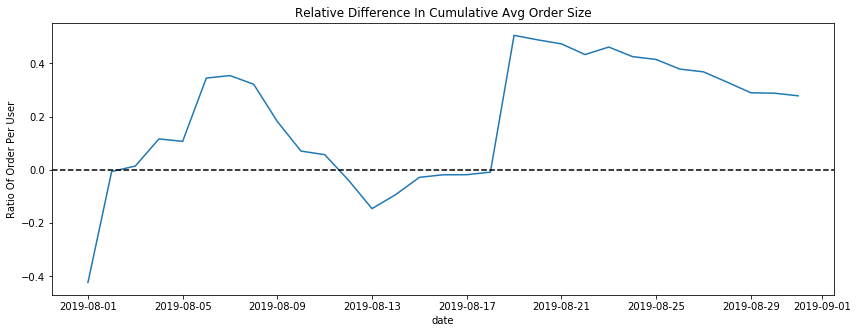

In [22]:
#graph the relative difference in cumulative average order size for group B compared with group A
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,left_on='date',right_on ='date',how='left',suffixes=['A',"B"])
fig = plt.figure(figsize = (14, 5))
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0,color='black',linestyle='--')
plt.title('Relative Difference In Cumulative Avg Order Size')
plt.xlabel('date')
plt.ylabel('Ratio Of Order Per User')
plt.show()

At several points the difference between the segment spikes. As there was several sudden and considerable changes. There is a possibility that they have to do with abnormally large purchases.

### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference.

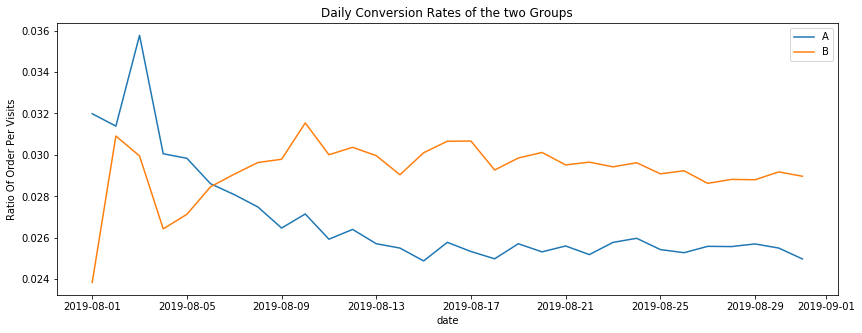

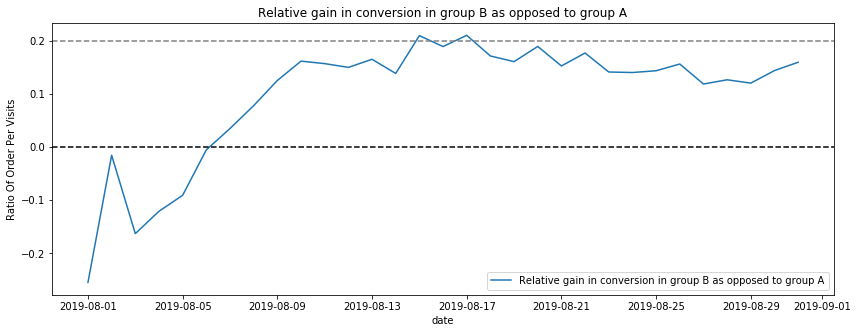

In [23]:
#Plot the daily conversion rates of the two groups
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=="B"]
fig = plt.figure(figsize = (14, 5))
plt.plot(cumulativeDataA['date'],cumulativeDataA['conversion'],label='A')
plt.plot(cumulativeDataB['date'],cumulativeDataB['conversion'],label='B')
plt.title('Daily Conversion Rates of the two Groups')
plt.xlabel('date')
plt.ylabel('Ratio Of Order Per Visits')
plt.legend()
#plt.axis(["2019-08-01","2019-08-31", -0.5, 0.5])
plt.show()

#graph of relative difference in conversion rate
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
fig = plt.figure(figsize = (14, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Relative gain in conversion in group B as opposed to group A")
plt.title('Relative gain in conversion in group B as opposed to group A')
plt.xlabel('date')
plt.ylabel('Ratio Of Order Per Visits')
plt.legend()

plt.axhline(y=0,color='black',linestyle='--')
plt.axhline(y=0.2,color='grey',linestyle='--')
#plt.axis(["2019-08-01","2019-08-31", -0.5, 0.5])
plt.show()



At the beginning of the test segment A had a heigher conversion rate, but segment B gradually gained and stabilised at an almost staedy value. We changed the graph's scale to make it clear that the absolute value of the fluctuation at the begning and end of the test wasn't that high from 2% to 4%. In relative terms it's almost twice as much.So if we remove the scale of the axes, it will seem that the values are still fluctuating & the conversion rate hasn't settled around its average value.

From the graph of relative difference in conversion rate. Group B was the leader in conversion almost from the very begning. It gained steady & stabikised at 15% heigher than group A. 

### Plot a scatter chart of the number of orders per user.

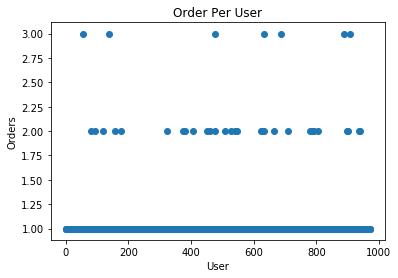

In [24]:
#scatter chart of the number of orders per user
ordersByUsers = orders_us_new.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['visitorId','orders']

# the range of numbers from 0 to the number of observations in ordersByUsers
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Order Per User')
plt.xlabel('User')
plt.ylabel('Orders')
plt.show()

There are very few users with more than two order. These cases may as well turn out to be anomalies.

### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly

In [25]:
#Calculate the 95th and 99th percentiles for the number of orders per user
print(np.percentile(ordersByUsers['orders'],[95,99]))

[1. 2.]


Not more than 5% users placed more than one order & not more than 1% of users made more than two orders.Let's define an anamolous users as those who place more than two orders.

### Plot a scatter chart of order prices

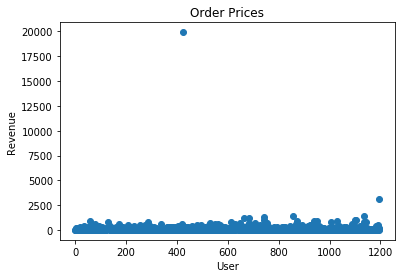

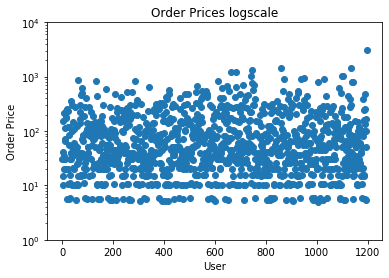

In [26]:
#plot a scatter chart of order prices
x_values = pd.Series(range(0,len(orders_us['revenue'])))
plt.scatter(x_values,orders_us['revenue'])
plt.title('Order Prices')
plt.xlabel('User')
plt.ylabel('Revenue')
plt.show()

plt.scatter(x_values,orders_us['revenue'])
plt.title('Order Prices logscale')
plt.xlabel('User')
plt.ylabel('Order Price')
plt.yscale('log')
plt.ylim(10**0,10**4)
plt.show()

There aren't many orders that costs more than 1500. There are outliers above 2500. Order of $20,000 looks pretty anomalous.

### Calculate the 95th and 99th percentiles of order prices

In [27]:
#Calculate the 95th and 99th percentiles of order prices
print(np.percentile(orders_us_new['revenue'],[95,99]))

[414.275 830.3  ]


Not more than 5% of users placed orders that costs more then dollar 414 & Not more than 1percent placed orders more expensive than dollar 830.

Let's define an anamolous users as those who place order price heigher than $830.

### Find the statistical significance of the difference in conversion between the groups using the raw data.

Test the hypothesis:
    
H0: The difference in conversion between the groups A and B is not statistically significant. M1 = M2
    
H1: The difference in conversion between the groups A and B is statistically significant. M1 != M2
    
Alpha is considered as 0.05 

In [28]:
#Find the statistical significance of the difference in conversion between the groups using the raw data
ordersByUsersA = orders_us_new[orders_us_new['group']=='A'].groupby('visitorId',as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersB = orders_us_new[orders_us_new['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId','orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits_us[visits_us['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits_us[visits_us['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB,alternative='two-sided')[1]))
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.01102
0.160


P- value is considerably lower than 0.05, so we reject the null hypothesis. The raw data analysis showed that the groups conversion rate have statistically significant differences. The relative conversion gain for group B compared with group A is 16%

### Find the statistical significance of the difference in average order size between the groups using the raw data.

Test the hypothesis:
    
H0: The difference in average order sizes between the groups A and B is not statistically significant. M1 = M2
    
H1: The difference in average order sizes between the groups A and B is statistically significant. M1 != M2
    
Alpha is considered as 0.05   

In [29]:
#Find the statistical significance of the difference in average order size between the groups using the raw data
print("{0:.3f}".format(stats.mannwhitneyu(orders_us_new[orders_us_new['group']=='A']['revenue'],orders_us_new[orders_us_new['group']=='B']['revenue'],alternative='two-sided')[1]))

print("{0:.3f}".format(orders_us_new[orders_us_new['group']=='B']['revenue'].mean()/orders_us_new[orders_us_new['group']=='A']['revenue'].mean()-1))


0.862
0.278


P-value is greater than 0.05,so we accept the null hypothesis. The raw data analysis showed that there is no statistical significance difference in average order size between groups. Moreover the relative difference is only 2.78%

### Find the statistical significance of the difference in conversion between the groups using the filtered data.

Let's define an anamolous users as those who place more than two orders or heigher than dollar 830

Test the hypothesis:
    
H0: Statistical significance of the groups conversion rate are same for the filtered data.
    
H1: Statistical significance of the groups conversion rate differs for the filtered data.

Alpha is considered as 0.05  

In [30]:
#Find the statistical significance of the difference in conversion between the groups using the filtered data
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders_us_new[orders_us_new['revenue'] > 830]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.shape)
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId']
                  .isin(abnormalUsers))]['orders'],pd.Series(0,index=np.arange(visits_us[visits_us['group']=='A']
                   ['visits'].sum()-len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId']
                  .isin(abnormalUsers))]['orders'],pd.Series(0,index=np.arange(visits_us[visits_us['group']=='B']
                  ['visits'].sum()-len(ordersByUsersB['orders'])),name='orders')],axis=0)


print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered,sampleBFiltered,alternative='two-sided')[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

(12,)
0.009
0.167


We have together 12 abonormal users in total as we considered only those who place more than 2 orders & with order size bigger than dollar 830. P- value is considerably lower than 0.05, so we reject the null hypothesis. The filtered data analysis showed that the groups conversion rate have statistically significant differences. The relative conversion gain for group B compared with group A is 16%

### Find the statistical significance of the difference in average order size between the groups using the filtered data

Test the hypothesis:
    
H0: Statistical significance of the groups average order sizes are same for the filtered data.
    
H1: Statistical significance of the groups average order sizes differs for the filtered data.

Alpha is considered as 0.05    

In [31]:
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

print("{0:.3f}".format(stats.mannwhitneyu(orders_us_new[np.logical_and(orders_us_new['group']=='A',
                np.logical_not(orders_us_new['visitorId'].isin(abnormalUsers)))]['revenue'],
                orders_us_new[np.logical_and(orders_us_new['group']=='B',
                np.logical_not(orders_us_new['visitorId'].isin(abnormalUsers)))]['revenue'],alternative='two-sided')[1]))

print("{0:.3f}".format(orders_us_new[np.logical_and(orders_us_new['group']=='B',np.logical_not(orders_us_new
                 ['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
                 orders_us_new[np.logical_and(orders_us_new['group']=='A',np.logical_not(
                 orders_us_new['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1))

0.988
-0.014


P-value is greater than 0.05,so we accept the null hypothesis. The filtered data analysis showed that there is no statistical significance difference in average order size between groups. We have negative relative average order size, this means that filtering out the outliers, relative average order size for group B compared with group A is -1.4%.

### Make a decision based on the test results.

General Conclusion:
    
We treated the dataset by dropping some of the visitors that might have gotten into both group A and group B. Then in order to prioritise the hypothesis we calculted the ICE & RICE framework. The most promising are hypothesis 7 when we use RICE instead of ICE. That's because it's reach parameter is 10, while the other hypothesis have lower values.

There is statistically significant difference in conversion between the groups,according to both the raw & filtered data.

The raw data didn't show a statistically significant difference between the groups in terms of average purchase size. However after removing the anomalies, it turned out that though there were no statistically significant difference but relative average order size for group B compared with group A is -1.4%.
    
The relative conversion gain for group B compared with group A was good for raw data but not for filtered data.
    
Hence,we can say that it worked well for the raw data as compared to filtered data.
    
Based on the facts listed above,stop the test call it a success.Consider group B as the leader.
   